---

# Assignment 5 - GitHub and the ticketmaster.com API

##### Marius Knipp (Student ID: 6290375)
##### January 25, 2023

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import requests
import time

---
### Getting to know the API

6) Whithin the scope of this assignment, you do not have to request your own API key. Instead retrieve a valid key from the API Explorer. This API key enables you to perform the GET requests needed throughout this assignment. Even though this API key is not secret per se (it is publicly visible on the API Explorer website), please comply to the common secrecy practices discussed in the lecture and the tutorial: Treat the API key as a secret token. Your API key should neither appear in the code that you are submitting nor in your public GitHub repository.

In [2]:
with open('ticketmaster_key.py') as script:
    exec(script.readline())

---

### Interacting with the API - the basics

7) Perform a first `GET` request, that searches for event venues in Germany (`countryCode = "DE"`). Extract the content from the response object and inspect the resulting list. Describe what you can see.

In [3]:
content = requests.get('https://app.ticketmaster.com/discovery/v2/venues',
                       params={'apikey': ticketmaster_key, 
                               'locale': '*',
                               'countryCode': 'DE'}).json()

In [4]:
content['page']

{'size': 20, 'totalElements': 12932, 'totalPages': 647, 'number': 0}

In [5]:
content['_embedded']['venues'][0].keys()

dict_keys(['name', 'type', 'id', 'test', 'url', 'locale', 'images', 'postalCode', 'timezone', 'city', 'country', 'address', 'location', 'markets', 'dmas', 'boxOfficeInfo', 'upcomingEvents', 'ada', '_links'])

*Answer: The list contains 20 venues in Germany with various information about each venue (e.g. name, URL, city etc.). These 20 venues are only on the first page. In total, there are 647 pages with 20 venues each, adding up to 12932 venues in Germany.*

8) Extract the `name`, the `city`, the `postalCode` and `address`, as well as the `url` and the `longitude` and `latitude` of the venues to a data frame.

In [6]:
venues_list = []
venues = content['_embedded']['venues']

for venue in venues:
    venue_dict = {}
    venue_dict['name'] = venue.get('name', np.nan)
    venue_dict['city'] = venue['city']['name'] if venue.get('city', None) else np.nan
    venue_dict['postalCode'] = venue.get('postalCode', np.nan)
    venue_dict['address'] = venue['address']['line1'] if venue.get('address', None) else np.nan
    venue_dict['url'] = venue.get('url', np.nan)
    venue_dict['longitude'] = venue['location']['longitude'] if venue.get('location', None) else np.nan
    venue_dict['latitude'] = venue['location']['latitude'] if venue.get('location', None) else np.nan
    venues_list.append(venue_dict)


df = pd.DataFrame(venues_list)
df.head()

,name,city,postalCode,address,url,longitude,latitude
0,Grosse Freiheit 36,Hamburg,22767,Grosse Freiheit 36,http://www.ticketmaster.de/venue/287636,9.957905,53.551187
1,Gruenspan,Hamburg,22767,Grosse Freiheit 58,http://www.ticketmaster.de/venue/287155,9.958075,53.551885
2,Huxleys Neue Welt,Berlin,10967,Hasenheide 107 – 113,http://www.ticketmaster.de/venue/286842,13.42138,52.486391
3,Zentrum am Park,Emmelshausen,56281,Rhein-Mosel-Straße 45,https://www.ticketmaster.de/venue/zentrum-am-p...,7.55656,50.15544
4,Stadthalle (Theatersaal),Mülheim,45479,Theodor-Heuss-Platz 1,https://www.ticketmaster.de/venue/stadthalle-t...,6.87471,51.42778


---

### Interacting with the API - advanced

9) Have a closer look at the list element named page. Did your `GET` request from exercise (7) return all event locations in Germany? Obviously not - there are of course much more venues in Germany than those contained in this list. Your `GET` request only yielded the first results page containing the first 20 out of several thousands of venues. Check the API documentation under the section Venue Search. How can you request the venues from the remaining results pages? Iterate over the results pages and perform `GET` requests for all venues in Germany. After each iteration, extract the seven variables `name`, `city`, `postalCode`, `address`, `url`, `longitude`, and `latitude`. Join the information in one large data frame. Print the first 10 rows and the shape of the resulting data frame. 

In [7]:
def get_venues(country):
    
    # Perform GET request to extract the number of total pages
    content = requests.get('https://app.ticketmaster.com/discovery/v2/venues',
                           params={'apikey': ticketmaster_key, 
                                   'locale': '*',
                                   'countryCode': country}).json()

    n_pages = content['page']['totalPages']
    
    # Empty list to store data
    venues_list = []
    
    # Iterate through pages
    for page in range(n_pages):
        # Limitation of 5 requests per second
        time.sleep(.2)
        
        # Perform GET request of the page in a while statement, 
        # because sometimes an error occurs, when performing the GET request
        venues = None
        while venues is None: 
            try:
                content = requests.get('https://app.ticketmaster.com/discovery/v2/venues.json?',
                                       params={'apikey': ticketmaster_key,
                                               'locale': '*',
                                               'countryCode': country, 
                                               'page': page}).json()

                venues = content['_embedded']['venues']
            except:
                pass
        
        # Iterate through venues on the page
        for venue in venues:
            # Extract the information and store it in a dictionary
            venue_dict = {}
            # Extract name if available
            venue_dict['name'] = venue.get('name', np.nan)
            # Extract city name if available
            venue_dict['city'] = venue['city']['name'] if venue.get('city', None) else np.nan
            # Extract postal code if available
            venue_dict['postalCode'] = venue.get('postalCode', np.nan)
            # Extract first value of address if available
            venue_dict['address'] = list(venue['address'].values())[0] if venue.get('address', None) else np.nan
            # Extract URL if available
            venue_dict['url'] = venue.get('url', np.nan)
            # Extract longitude if available
            venue_dict['longitude'] = venue['location']['longitude'] if venue.get('location', None) else np.nan
            # Extract latitude if available
            venue_dict['latitude'] = venue['location']['latitude'] if venue.get('location', None) else np.nan
            
            # Append the dictionary to the list
            venues_list.append(venue_dict)
    
    # Convert list of dictionaries to a data frame
    venues_df = pd.DataFrame(venues_list)
    return venues_df

In [8]:
venues_germany = get_venues('DE')
venues_germany.head(10)

,name,city,postalCode,address,url,longitude,latitude
0,Grosse Freiheit 36,Hamburg,22767,Grosse Freiheit 36,http://www.ticketmaster.de/venue/287636,9.957905,53.551187
1,Gruenspan,Hamburg,22767,Grosse Freiheit 58,http://www.ticketmaster.de/venue/287155,9.958075,53.551885
2,Huxleys Neue Welt,Berlin,10967,Hasenheide 107 – 113,http://www.ticketmaster.de/venue/286842,13.42138,52.486391
3,Zentrum am Park,Emmelshausen,56281,Rhein-Mosel-Straße 45,https://www.ticketmaster.de/venue/zentrum-am-p...,7.55656,50.15544
4,Stadthalle (Theatersaal),Mülheim,45479,Theodor-Heuss-Platz 1,https://www.ticketmaster.de/venue/stadthalle-t...,6.87471,51.42778
5,Schlossgarten,Bruchsal,76646,Schloss Bruchsal,https://www.ticketmaster.de/venue/schlossgarte...,8.59908,49.12692
6,Stadthalle,Hockenheim,68766,Rathausstraße 3,https://www.ticketmaster.de/venue/stadthalle-h...,8.54908,49.31849
7,FZW,Dortmund,44263,Ritterstraße 20,https://www.ticketmaster.de/venue/fzw-dortmund...,7.4501,51.51481
8,Arena Trier,Trier,54292,Fort-Worth-Platz 1,https://www.ticketmaster.de/venue/arena-trier-...,6.66426,49.77183
9,Eissporthalle,Memmingen,87700,Hühnerbergstraße 19,https://www.ticketmaster.de/venue/eissporthall...,10.16293,47.97999


In [9]:
venues_germany.shape

(12932, 7)

---

### Visualizing the extracted data

10) Below, you can find code that produces a map of Germany. Add points to the map indicating the locations of the event venues across Germany.


11) You will find that some coordinates lie way beyond the German borders and can be assumed to be faulty. Set coordinate values to `NA` where the value of `longitude` is outside the range (`5.866, 15.042`) or where the value of `latitude` is outside the range (`47.270, 55.059`).

In [11]:
def plot_venues(venues, country, lo_min, lo_max, lat_min, lat_max):
    
    # Change data type of 'longitude' and 'latitude' to float
    venues[['longitude', 'latitude']] = venues[['longitude', 'latitude']].astype(float)
    
    # Set coordinates outside the range to NaN
    venues['longitude'] = venues['longitude'].mask((venues['longitude'] < lo_min) |
                                                   (venues['longitude'] > lo_max))
    venues['latitude'] = venues['latitude'].mask((venues['latitude'] < lat_min) |
                                                 (venues['latitude'] > lat_max))
    
    # Get a base map the country
    map = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
    map = map[map.name == country]

    fig, ax = plt.subplots()

    # Plot the map
    map.plot(ax = ax)

    # Plot the venues
    x = venues['longitude']
    y = venues['latitude']
    plt.scatter(x, y, s=1, color='red')

    plt.show()

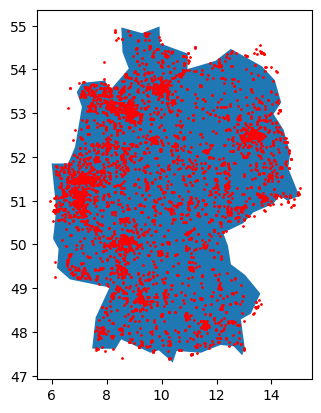

In [12]:
# Extreme points of Germany
lo_min, lo_max = 5.866, 15.042
lat_min, lat_max = 47.270, 55.059

plot_venues(venues_germany, 'Germany', lo_min, lo_max, lat_min, lat_max)